In [10]:
# Importing libraries for data handling, image processing, and deep learning
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split


In [11]:
# Setting a fixed seed for reproducibility across random operations
import random
import numpy as np
import torch

# Set the seed for reproducibility
seed = 42  # Chosen seed value for consistent results
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed_all(seed)  # PyTorch GPU (all devices)

# Ensure reproducibility in data loader shuffling and other parallel computations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [12]:
# Define paths for the dataset, data folder, and example files
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
eg_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'


In [13]:
# Dataset class for loading and preprocessing brain MRI images and masks
class BrainDataset(Dataset):
    def __init__(self, path=None, transform=None):
        """
        Initialize the dataset by collecting and pairing images and masks.
        
        Args:
            path (str): Path to the directory containing patient folders with images and masks.
            transform (albumentations.Compose, optional): Transformation pipeline to apply to images and masks.
        """
        self.transform = transform
        self.images, self.masks = [], []

        # Exclude unnecessary files and gather valid patient directories
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv', 'README.md']]

        # Collect all image and mask paths
        for patient in self.patients:
            patient_path = os.path.join(path, patient)
            if os.path.isdir(patient_path):
                for file in os.listdir(patient_path):
                    if "mask" in file.lower():
                        self.masks.append(os.path.join(patient_path, file))
                    else:
                        self.images.append(os.path.join(patient_path, file))
        
        # Ensure images and masks are sorted for correct pairing
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)

    def __len__(self):
        # Return the total number of images
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Fetch a paired image and mask by index.
        
        Returns:
            tuple: (image, mask) where image is normalized and transformed.
        """
        # Load and normalize the image and mask
        image = cv2.imread(self.images[idx])
        image = np.array(image) / 255.0
        mask = cv2.imread(self.masks[idx], 0)  # Load mask in grayscale
        mask = np.array(mask) / 255.0
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to PyTorch tensors and format appropriately
        image = image.transpose((2, 0, 1))  # Convert to channel-first format
        image = torch.from_numpy(image).float()
        
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension to mask
        mask = torch.from_numpy(mask).float()
        
        return image, mask


In [9]:
import albumentations as A  # Image augmentations

# Define train and test transformations
train_transform = A.Compose([
    A.Resize(width=256, height=256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
])
test_transform = A.Compose([
    A.Resize(width=256, height=256,p=1.0),
])

# Step 1: Load the entire dataset
full_dataset = BrainDataset(path=data_folder, transform=None)

# Step 2: Split the dataset into training and testing subsets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 3: Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Step 4: Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Step 5: Fetch a batch for verification
images, masks = next(iter(train_loader))
print(images.shape)  # Should be (batch_size, 3, 256, 256) or (batch_size, 1, 256, 256) for grayscale
print(masks.shape)   # Should be (batch_size, 1, 256, 256)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


In [14]:
import torch
import torch.nn as nn

# Basic convolutional block: Conv2D -> BatchNorm -> ReLU
class convblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(convblock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

# Encoder block: Two convblocks followed by max pooling
class stackEncoder(nn.Module):
    def __init__(self, channel1, channel2, kernel_size=3, padding=1):
        super(stackEncoder, self).__init__()
        self.block = nn.Sequential(
            convblock(channel1, channel2, kernel_size, padding),
            convblock(channel2, channel2, kernel_size, padding)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        fordecoder = self.block(x)  # Output for skip connection
        normal = self.maxpool(fordecoder)  # Downsampled output
        return fordecoder, normal

# Decoder block: Upsampling -> skip connection -> two convblocks
class stackDecoder(nn.Module):
    def __init__(self, big_channel, channel1, channel2, kernel_size=3, padding=1):
        super(stackDecoder, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels=big_channel, out_channels=big_channel, kernel_size=2, stride=2
        )
        self.block = nn.Sequential(
            convblock(channel1 + big_channel, channel2, kernel_size, padding),
            convblock(channel2, channel2, kernel_size, padding=padding),
        )

    def forward(self, x, dow_tensor):
        x = self.upsample(x)  # Upsample the input
        x = torch.cat([x, dow_tensor], dim=1)  # Concatenate with the skip connection
        x = self.block(x)  # Apply two convblocks
        return x

# U-Net model
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        # Define the encoder
        self.down1 = stackEncoder(3, 64)      # Output size: 256 -> 128, Channels: 3 -> 64
        self.down2 = stackEncoder(64, 128)   # Output size: 128 -> 64, Channels: 64 -> 128
        self.down3 = stackEncoder(128, 256)  # Output size: 64 -> 32, Channels: 128 -> 256
        self.down4 = stackEncoder(256, 512)  # Output size: 32 -> 16, Channels: 256 -> 512
        self.down5 = stackEncoder(512, 1024) # Output size: 16 -> 8, Channels: 512 -> 1024

        # Bottleneck layer
        self.center = convblock(1024, 1024)  # Output size: 8 -> 8, Channels: 1024 -> 1024

        # Define the decoder
        self.up5 = stackDecoder(1024, 1024, 512)  # Output size: 8 -> 16, Channels: 1024 -> 512
        self.up4 = stackDecoder(512, 512, 256)    # Output size: 16 -> 32, Channels: 512 -> 256
        self.up3 = stackDecoder(256, 256, 128)    # Output size: 32 -> 64, Channels: 256 -> 128
        self.up2 = stackDecoder(128, 128, 64)     # Output size: 64 -> 128, Channels: 128 -> 64
        self.up1 = stackDecoder(64, 64, 32)       # Output size: 128 -> 256, Channels: 64 -> 32

        # Final output layer
        self.conv = nn.Conv2d(32, 1, kernel_size=1, bias=True)  # Final output: Channels: 32 -> 1

    def forward(self, x):
        # Encoder
        down1, out = self.down1(x)  # Downsample 1: Size 256 -> 128
        down2, out = self.down2(out)  # Downsample 2: Size 128 -> 64
        down3, out = self.down3(out)  # Downsample 3: Size 64 -> 32
        down4, out = self.down4(out)  # Downsample 4: Size 32 -> 16
        down5, out = self.down5(out)  # Downsample 5: Size 16 -> 8

        # Center (bottleneck)
        out = self.center(out)  # Bottleneck: Size 8 -> 8

        # Decoder
        up5 = self.up5(out, down5)  # Upsample 5: Size 8 -> 16
        up4 = self.up4(up5, down4)  # Upsample 4: Size 16 -> 32
        up3 = self.up3(up4, down3)  # Upsample 3: Size 32 -> 64
        up2 = self.up2(up3, down2)  # Upsample 2: Size 64 -> 128
        up1 = self.up1(up2, down1)  # Upsample 1: Size 128 -> 256

        # Final output
        out = self.conv(up1)  # Final convolution: Output Size 256
        out = torch.sigmoid(out)  # Apply sigmoid activation for binary segmentation

        return out


In [13]:
# Function to calculate the Dice coefficient metric between prediction and ground truth
def dice_coef_metric(pred, label, smooth=1e-6):
    """
    Computes the Dice coefficient for evaluating segmentation performance.

    Args:
        pred (torch.Tensor): Predicted segmentation map.
        label (torch.Tensor): Ground truth segmentation map.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        torch.Tensor: Dice coefficient.
    """
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum() + smooth
    return intersection / union

# Tversky loss for imbalanced segmentation problems
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        """
        Initializes the Tversky loss function.

        Args:
            alpha (float): Weight for false positives.
            beta (float): Weight for false negatives.
            smooth (float): Smoothing factor to avoid division by zero.
        """
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, preds, labels):
        """
        Computes the Tversky loss.

        Args:
            preds (torch.Tensor): Predicted segmentation map.
            labels (torch.Tensor): Ground truth segmentation map.

        Returns:
            torch.Tensor: Tversky loss.
        """
        preds = preds.view(-1)
        labels = labels.view(-1)

        TP = (preds * labels).sum()  # True positives
        FP = ((1 - labels) * preds).sum()  # False positives
        FN = (labels * (1 - preds)).sum()  # False negatives

        tversky_index = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky_index

# Tversky metric for evaluating segmentation performance
def tversky_metric(preds, labels, alpha=0.3, beta=0.7, smooth=1e-6):
    """
    Computes the Tversky index for evaluating segmentation performance.

    Args:
        preds (torch.Tensor): Predicted segmentation map.
        labels (torch.Tensor): Ground truth segmentation map.
        alpha (float): Weight for false positives.
        beta (float): Weight for false negatives.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        torch.Tensor: Tversky index.
    """
    preds = preds.view(-1)
    labels = labels.view(-1)

    TP = (preds * labels).sum()  # True positives
    FP = ((1 - labels) * preds).sum()  # False positives
    FN = (labels * (1 - preds)).sum()  # False negatives

    tversky_index = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return tversky_index


In [14]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the U-Net model
unet = Unet()

# Enable multi-GPU support if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    unet = nn.DataParallel(unet)

# Move the model to the selected device
unet = unet.to(device)

# Initialize Tversky Loss
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)

# Initialize the optimizer
optimizer = Adam(unet.parameters(), lr=1e-4)

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

# Variables to track the best metrics
best_dice_score = 0
best_tversky_score = 0

# Lists to store metrics for training and testing
train_losses, train_dice_scores, train_tversky_scores = [], [], []
test_losses, test_dice_scores, test_tversky_scores = [], [], []

# Set the number of epochs
num_epochs = 50

# Training and testing loop
for epoch in range(num_epochs):
    # Training phase
    unet.train()
    train_loss, train_dice, train_tversky = 0, 0, 0

    for data, target in train_loader:
        # Move data and labels to the device
        data, target = data.to(device).float(), target.to(device).float()

        # Forward pass
        output = unet(data)

        # Compute the loss
        loss = tversky_loss(output, target)
        train_loss += loss.item()

        # Compute metrics
        out_cut = (output >= 0.5).float()
        train_dice += dice_coef_metric(out_cut, target).item()
        train_tversky += tversky_metric(out_cut, target).item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average training metrics
    train_losses.append(train_loss / len(train_loader))
    train_dice_scores.append(train_dice / len(train_loader))
    train_tversky_scores.append(train_tversky / len(train_loader))

    # Testing phase
    unet.eval()
    test_loss, test_dice, test_tversky = 0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            # Move data and labels to the device
            data, target = data.to(device).float(), target.to(device).float()

            # Forward pass
            output = unet(data)

            # Compute the loss
            loss = tversky_loss(output, target)
            test_loss += loss.item()

            # Compute metrics
            out_cut = (output >= 0.5).float()
            test_dice += dice_coef_metric(out_cut, target).item()
            test_tversky += tversky_metric(out_cut, target).item()

    # Compute average testing metrics
    test_losses.append(test_loss / len(test_loader))
    test_dice_scores.append(test_dice / len(test_loader))
    test_tversky_scores.append(test_tversky / len(test_loader))

    # Adjust learning rate based on validation Dice score
    scheduler.step(test_dice_scores[-1])

    # Log metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.6f}, Train Dice: {train_dice_scores[-1]:.6f}, Train Tversky: {train_tversky_scores[-1]:.6f}, "
          f"Test Loss: {test_losses[-1]:.6f}, Test Dice: {test_dice_scores[-1]:.6f}, Test Tversky: {test_tversky_scores[-1]:.6f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save the best model based on Dice score
    if test_dice_scores[-1] > best_dice_score:
        best_dice_score = test_dice_scores[-1]
        torch.save(unet.state_dict(), "/kaggle/working/best_dice_model.pth")
        print(f"Best Dice model saved at epoch {epoch+1} with Dice score: {best_dice_score:.6f}")

    # Save the best model based on Tversky score
    if test_tversky_scores[-1] > best_tversky_score:
        best_tversky_score = test_tversky_scores[-1]
        torch.save(unet.state_dict(), "/kaggle/working/best_tversky_model.pth")
        print(f"Best Tversky model saved at epoch {epoch+1} with Tversky score: {best_tversky_score:.6f}")


cuda
Using 2 GPUs!
Epoch 1/50, Train Loss: 0.93163753, Train Dice: 0.15174176, Train Tversky: 0.21990718, Test Loss: 0.92612872, Test Dice: 0.20619411, Test Tversky: 0.28398397, LR: 0.000100
Best Dice model saved at epoch 1 with Dice score: 0.20619411
Best Tversky model saved at epoch 1 with Tversky score: 0.28398397
Epoch 2/50, Train Loss: 0.91291575, Train Dice: 0.22602648, Train Tversky: 0.31212001, Test Loss: 0.90342649, Test Dice: 0.27165735, Test Tversky: 0.36353938, LR: 0.000100
Best Dice model saved at epoch 2 with Dice score: 0.27165735
Best Tversky model saved at epoch 2 with Tversky score: 0.36353938
Epoch 3/50, Train Loss: 0.89632814, Train Dice: 0.28345309, Train Tversky: 0.37673801, Test Loss: 0.89010997, Test Dice: 0.31818840, Test Tversky: 0.41343086, LR: 0.000100
Best Dice model saved at epoch 3 with Dice score: 0.31818840
Best Tversky model saved at epoch 3 with Tversky score: 0.41343086
Epoch 4/50, Train Loss: 0.87634502, Train Dice: 0.30680608, Train Tversky: 0.4004

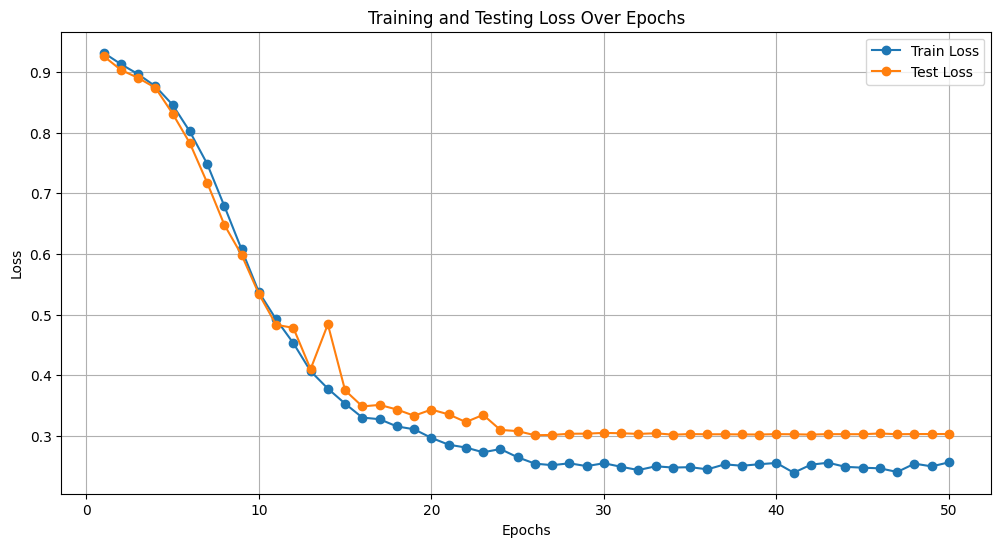

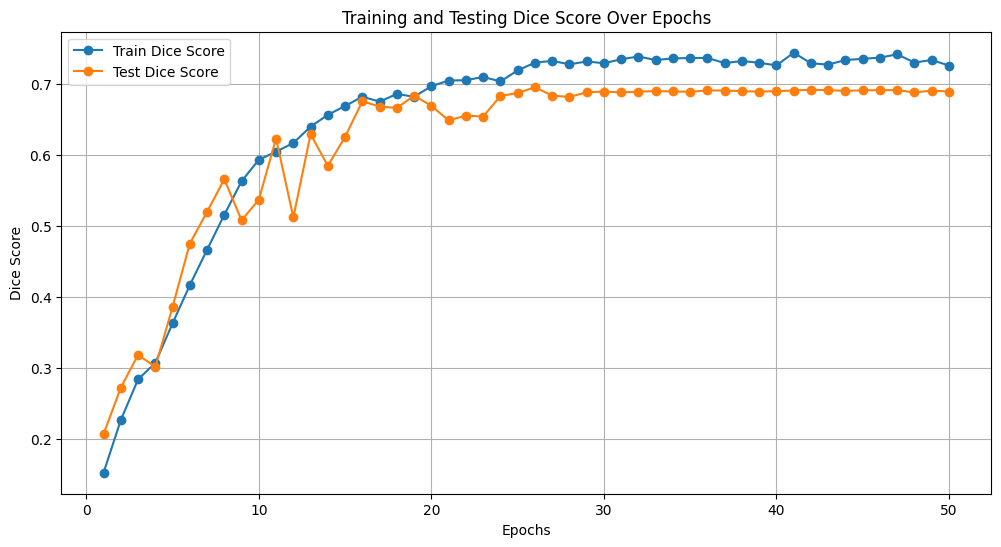

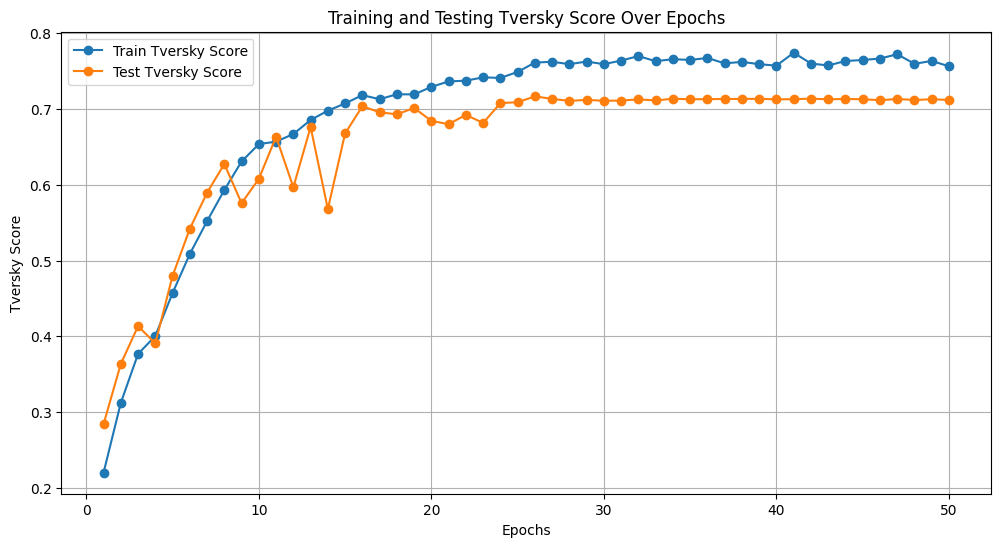

In [15]:
import matplotlib.pyplot as plt

# Plot training and testing losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot training and testing Dice scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_dice_scores, label="Train Dice Score", marker='o')
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Test Dice Score", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.title("Training and Testing Dice Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot training and testing Tversky scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_tversky_scores, label="Train Tversky Score", marker='o')
plt.plot(range(1, num_epochs + 1), test_tversky_scores, label="Test Tversky Score", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Tversky Score")
plt.title("Training and Testing Tversky Score Over Epochs")
plt.legend()
plt.grid()
plt.show()


Using device: cpu


<ipython-input-16-bb6bdf2c184c>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


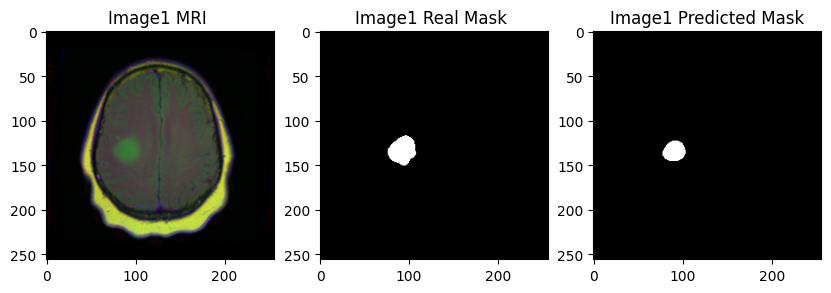

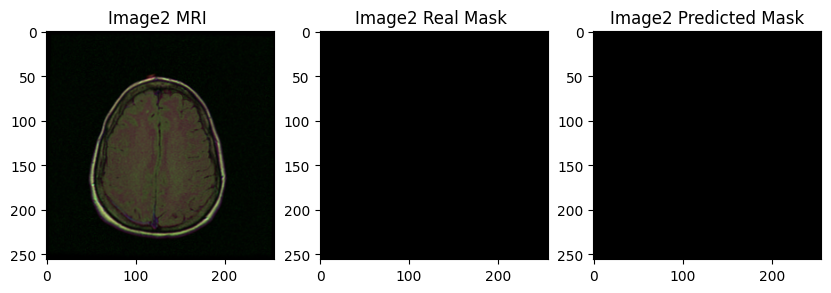

In [16]:
import cv2
import torch
import matplotlib.pyplot as plt
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict


def load_and_transform(image_path, mask_path, transform):
    """
    Load an image and its corresponding mask, apply transformations, and return the processed tensors.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the ground truth mask.
        transform (albumentations.Compose): Transformation pipeline to apply.

    Returns:
        tuple: Original image (RGB), original mask (RGB), and transformed image tensor.
    """
    # Read the image and mask in BGR format
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Convert image and mask to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Apply transformations to the image
    transformed = transform(image=image)
    image_tensor = transformed["image"]

    return image, mask, image_tensor


def plot_results(image_rgb, mask_rgb, pred_mask, title_prefix):
    """
    Plot the original image, ground truth mask, and predicted mask.

    Args:
        image_rgb (ndarray): Original input image in RGB.
        mask_rgb (ndarray): Ground truth mask in RGB.
        pred_mask (ndarray): Predicted binary mask.
        title_prefix (str): Title prefix for the plot.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix} MRI")
    plt.imshow(image_rgb)  # Original MRI image

    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix} Real Mask")
    plt.imshow(mask_rgb)  # Ground truth mask

    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix} Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')  # Predicted mask

    plt.show()


# Define paths for images and masks
paths = [
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14_mask.tif",
        "title": "Image1"
    },
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif",
        "title": "Image2"
    }
]

# Define transformations
transform = Compose([
    Resize(256, 256),  # Resize images to 256x256
    Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),  # Normalize pixel values
    ToTensorV2()  # Convert to PyTorch tensor
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Unet().to(device)
model.eval()

# Load model checkpoint and handle potential DataParallel "module." prefix issue
checkpoint_path = "/kaggle/input/tv/pytorch/default/1/best_tversky_model (3).pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Adjust state dictionary keys if DataParallel was used during training
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = k[len("module."):] if k.startswith("module.") else k
    new_state_dict[name] = v

# Load the adjusted state dictionary into the model
model.load_state_dict(new_state_dict, strict=True)

# Process and visualize images and masks
for path in paths:
    # Load and transform the image and mask
    image, mask, image_tensor = load_and_transform(path["image"], path["mask"], transform)

    # Prepare the input tensor for the model
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Generate predictions
    with torch.no_grad():
        output = model(image_tensor.float())
        output_mask = (output >= 0.5).float()  # Apply threshold for binary mask

    # Convert predictions to numpy array
    predicted_mask_np = output_mask.squeeze().cpu().numpy()

    # Resize the ground truth mask for comparison
    mask_rgb_resized = cv2.resize(mask, (256, 256))

    # Plot and compare the results
    plot_results(image, mask_rgb_resized, predicted_mask_np, path["title"])
